In [1]:
#All Required Libraries
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available() #Check if it is possible to use GPU.

In [22]:
#Toy Example of ODE Solver (Euler IV Solver)
def ode_solve2(z0,t0,t1,f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())
    h = (t1 - t0)/n_steps
    for i_step in range(n_steps):
        k1 = f(z0,t0)
        k2 = f(z0 + h/2 * k1, t0 + h/2)
        k3 = f(z0 + h/2 * k2, t0 + h/2)
        k4 = f(z0 +h*k3, t0 + h/2)
        z0 = h/6*(k1 + 2*k2 + 2*k3 + k4)
        t0 = t0 + h
    return z0
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [3]:
#Calculates Forward Pass and Gradients of the Loss function wrt z,t,parameters.
#Compute f and a df/dz, a df/dp, a df/dt (i.e., da(t)/dt)
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        batch_size = z.shape[0]

        out = self.forward(z, t) #Calculates the forward pass of the model.

        a = grad_outputs #Gradient of the model's output (out) wrt z, t, and all the model parameters.
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0) #Creates a list of flattened parameter gradients.
            adfdp = adfdp.expand(batch_size, -1) / batch_size #Create the gradient tensor for each batchsize, second dim is unchanged (i.e., 1 for each parameter).
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size #Same as for the parameters but the second dimension is 1 as there is only 1 "parameter".
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [4]:
#Calculates Forward and Backward Pass and Gradients with Adjoint Method.
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF) #Make sure func is an instance of ODEF.
        bs, *z_shape = z0.size() #bs (batchsize), z_shape (shape of initial state z0) - The asterisk * is used to collect the remaining elements of the tuple (all except the first). 
        time_len = t.size(0)

        with torch.no_grad(): #Operations not tracked for gradient calculation.
            z = torch.zeros(time_len, bs, *z_shape).to(z0) #Initialize z as zeros of t,bs,z in the same device (CPU/GPU) as z0.
            z[0] = z0 #Define initial value.
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func) #Solve ODE with shape f(z(0),t_i,t_f) in steps.
                z[i_t+1] = z0

        ctx.func = func #Store the function to use it later in the Backpropagation,
        ctx.save_for_backward(t, z.clone(), flat_parameters) #Same for the tensors for time, trajectory (z) and parameters.
        return z

    @staticmethod
    def backward(ctx, dLdz): #a(t) = dLdz
        #dLdz shape: time_len, batch_size, *z_shape
        func = ctx.func #This is the ODE Function.
        t, z, flat_parameters = ctx.saved_tensors #Our saved tensors from Forward Pass.
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape) #Number of dimensions of z.
        n_params = flat_parameters.size(0) #Number of parameters.

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF) #Checks if the argument func is part of the ODEF.
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0) #It ensures that the time tensor t is on the same device as the input z0.
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func) #Numerically integrating the ODE over the specified time range using an adjoint method (Backpropagation).
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [6]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

In [7]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

In [8]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

In [9]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1) #Dot product between x and x0, sum along dim 1.
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0) #ODE Dynamics
        return dxdt

In [10]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim) #Doesn't include time.
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim) #Includes time.
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True) #Exponential Linear Unit activation function after each linear layer.

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1) #If not time-invariant, concatenate time to state x.

        h = self.elu(self.lin1(x)) #Input into first layer.
        h = self.elu(self.lin2(h)) #Second layer.
        out = self.lin3(h) #Last layer.
        return out

In [20]:
# Detaches a PyTorch tensor from its computation graph, moves it to the CPU if it's on the GPU, and then converts it to a NumPy array.
def to_np(x):
    return x.detach().cpu().numpy()

In [11]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
           z = to_np(z)
           plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5) 
           #plt.plot(to_np(z[:]), z[:, 0, 1],  lw=1.5)
           plt.xlabel('Rotor Declincation Angle')
           plt.ylabel('Angular Frequency Deviation')
           plt.title('Parametric Plot')

        if save is not None:
            plt.savefig(save)
    plt.show()

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_trajectories2(real, obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)
                #plt.scatter(o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None: 
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5, label='z[:, 0, 0] vs z[:, 0, 1]')
            plt.xlabel('Rotor Declination Angle')
            plt.ylabel('Angular Frequency Deviation')
            plt.title('Parametric Plot')

            if times is not None:
                t = to_np(times[0])  # Assuming all trajectories share the same time axis
                t = t[:, 0, 0]  # Flatten t to 1D
                plt.figure(figsize=figsize)  # Create a new figure for z[:, 0, 1] vs time
                plt.plot(t, z[:, 0, 1], lw=1.5, label='z[:, 0, 1] vs time')
                plt.plot(t, real[:,0,1], lw=1.5)
                plt.xlabel('Time')
                plt.ylabel('Angular Frequency Deviation')
                plt.title('Angular Frequency Deviation vs Time')
                if save is not None:
                    plt.savefig(save + "_time_vs_z01.png")  # Save the time vs z[:, 0, 1] plot
    
    # Add legend for the two plots
    plt.legend()
    plt.show()


In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())
conduct_experiment(ode_true, ode_trained, 1000, "linear")

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)
func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

In [24]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    #z0 = Variable(torch.Tensor([[0.6, 0.3]]))
    z0 = Variable(torch.Tensor([[0., 0.]]))

    #t_max = 6.29*5
    t_max = 60.0
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    real = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan 
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.05)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories2(real, obs=[obs], times=[times], trajs=[z_p], save=None)
            print('Iteration: {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            clear_output(wait=True)


In [14]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())
conduct_experiment(ode_true, ode_trained, 1000, "linear")

NameError: name 'to_np' is not defined

<Figure size 1600x800 with 0 Axes>

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)
func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

In [16]:
class GridODE(ODEF):
    def __init__(self, M, D, B, G):
        super(GridODE, self).__init__()
        self.M = nn.Parameter(M)
        self.D = nn.Parameter(D)
        self.B = nn.Parameter(B)
        self.G = nn.Parameter(G)
        
    def forward(self, x, t):
        x_prime = x[:,1]
        x_prime_prime = (-self.D * x_prime + self.B * torch.sin(x[:, 0]) - self.G * torch.cos(x[:, 0])) / self.M
        x_prime_prime = x_prime_prime.view(-1)
        return torch.stack((x_prime, x_prime_prime), dim=1)

In [17]:
class RealGrid(GridODE):
    def __init__(self, M, D, B, G):
        super(RealGrid, self).__init__(M, B, D, G)

In [18]:
class EstimatedGrid(GridODE):
    def __init__(self, M, D, B, G):
        super(EstimatedGrid, self).__init__(M, B, D, G)

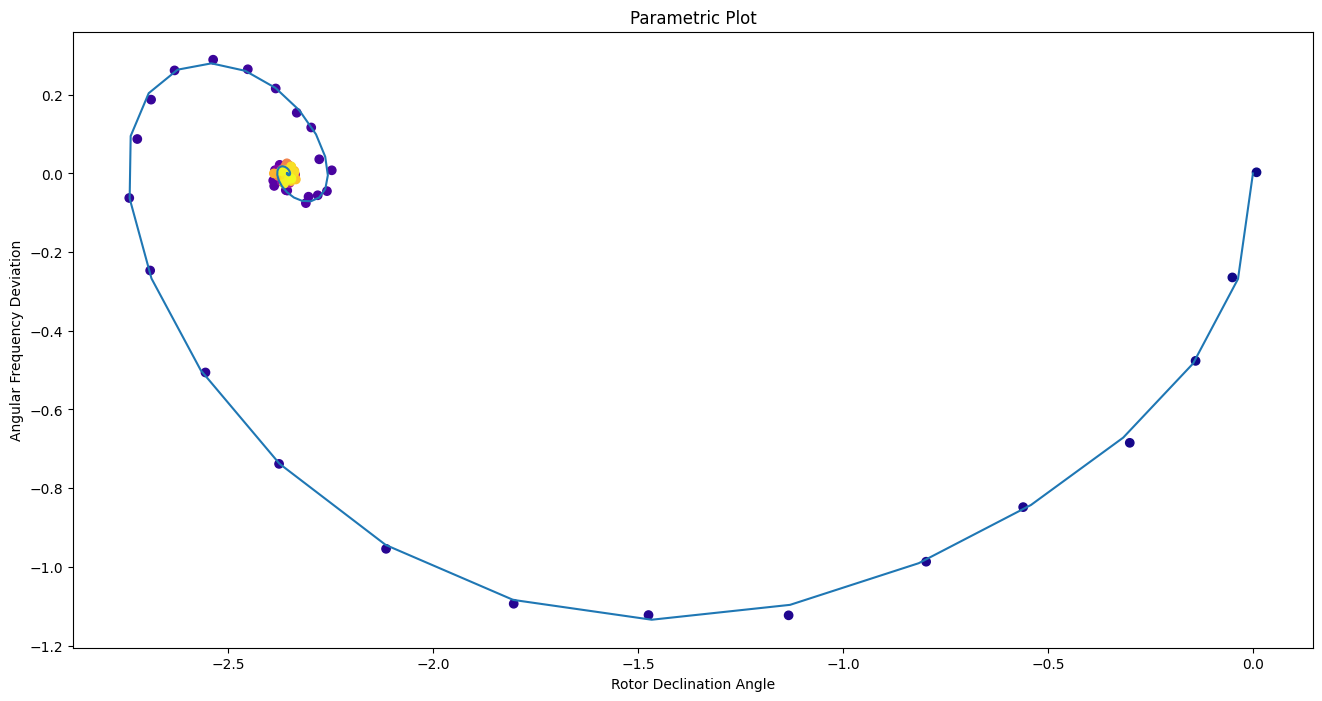

KeyboardInterrupt: 

In [26]:
ode_true = NeuralODE(RealGrid(Tensor([[1]]), Tensor([[1]]), Tensor([[1]]), Tensor([[1]])))
ode_trained = NeuralODE(EstimatedGrid(torch.randn(1,1), torch.randn(1,1),torch.randn(1,1),torch.randn(1,1)))
conduct_experiment(ode_true, ode_trained, 1000, "3Bus System")

In [ ]:
z0 = Variable(torch.Tensor([[0., 0.]]))

#t_max = 6.29*5
t_max = 60.0
n_points = 200

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])

times = torch.from_numpy(times_np[:, :, None]).to(z0)
real = ode_true(z0, times, return_whole_sequence=True).detach()
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs + torch.randn_like(obs) * 0.01

min_delta_time = 1.0
max_delta_time = 5.0
max_points_num = 32
z_ = ode_trained(obs[0], times, return_whole_sequence=True)

print(times.size())